# Instance Segmentation

In [1]:
import torch
import torchvision.transforms as T
import torchvision
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import cv2

In [2]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) # backbone resenet50 => feature extraction, feature pyramid netword => 
model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [3]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
 
def get_prediction(img_path, threshold):
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy()) # score de confidencia => > threshold
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  #thershold para máscaras mayor a 0.5
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy() # val > 0.5 => mask
  #agregamos los labels correspondientes a la lista COCO INSTANCE
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [4]:
def random_colour_masks(image):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],
             [80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

In [5]:
def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, 
                text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [6]:
!wget dealain.com/descargas/maskrcnn_files.zip
!unzip maskrcnn_files.zip

--2020-11-08 16:21:46--  http://dealain.com/descargas/maskrcnn_files.zip
Resolving dealain.com (dealain.com)... 192.185.91.239
Connecting to dealain.com (dealain.com)|192.185.91.239|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37755413 (36M) [application/zip]
Saving to: ‘maskrcnn_files.zip’

maskrcnn_files.zip  100%[===================>]  36.01M  33.1MB/s    in 1.1s    

2020-11-08 16:21:47 (33.1 MB/s) - ‘maskrcnn_files.zip’ saved [37755413/37755413]

Archive:  maskrcnn_files.zip
  inflating: familia1.jpeg           
  inflating: familia2.jpeg           
  inflating: personas.jpeg           


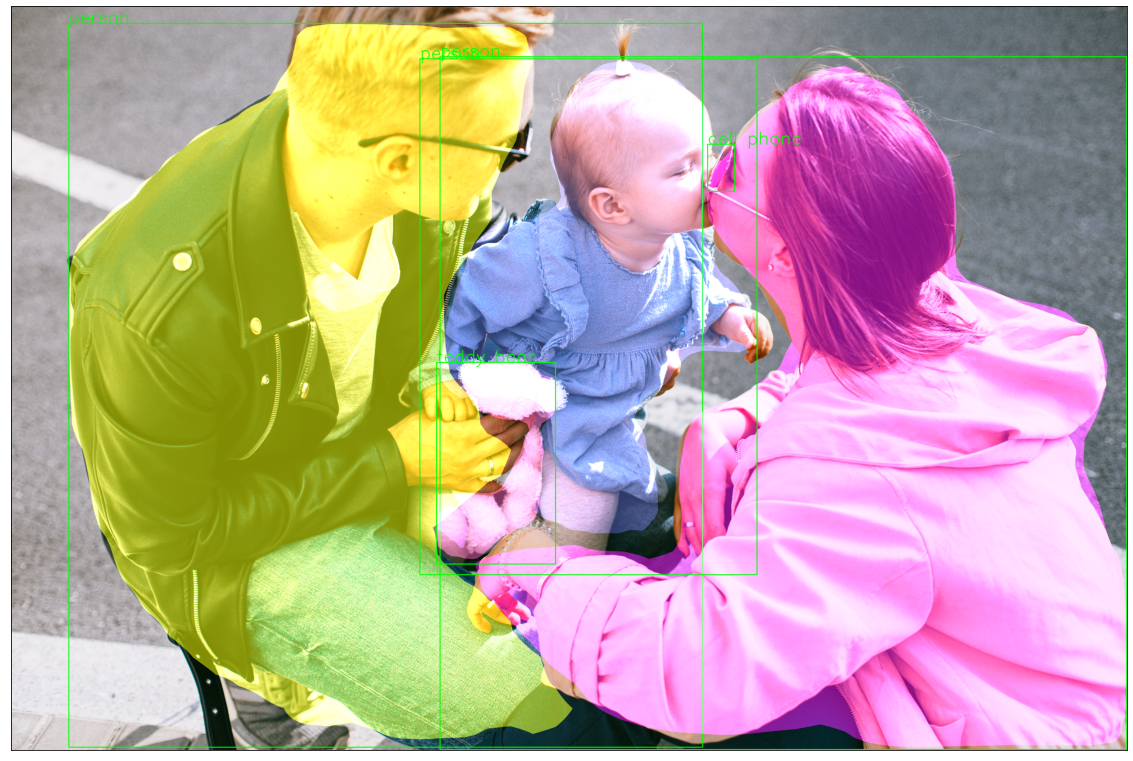

In [10]:
instance_segmentation_api('familia2.jpeg')

In [7]:
import gdown

url = 'https://drive.google.com/uc?id=1s5TeREqsZNT3M9HVVOp1hM_mGnWAVRRR'
output = 'vid1.MP4'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1s5TeREqsZNT3M9HVVOp1hM_mGnWAVRRR
To: /content/vid1.MP4
12.0MB [00:00, 119MB/s]


'vid1.MP4'

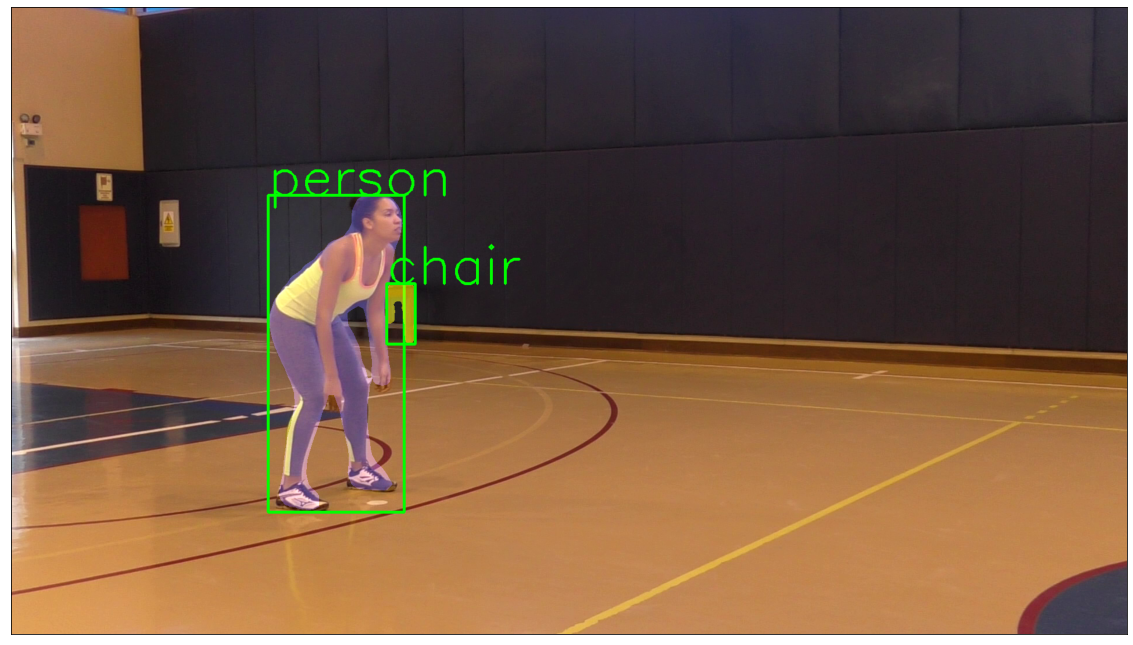

In [11]:
vs =cv2.VideoCapture(output)
(grab, frame) = vs.read()

cv2.imwrite('frame.png', frame)

instance_segmentation_api('frame.png')

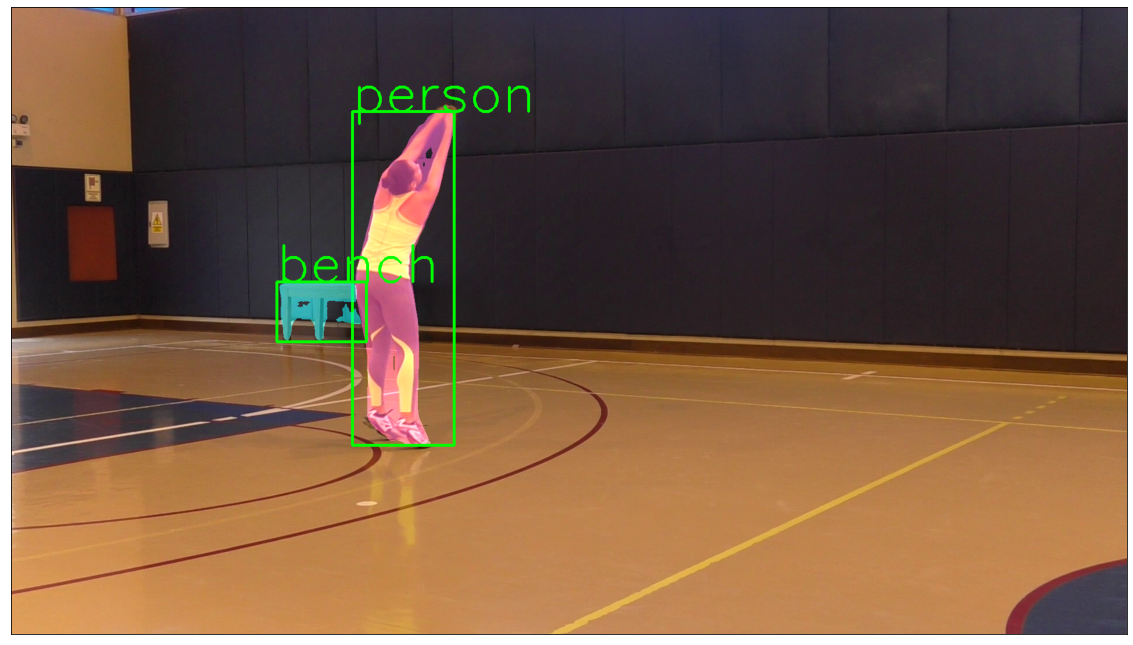

In [12]:
i = 0

frame = []

while i<121:
  (grab, frame) = vs.read()
  i+=1

cv2.imwrite('frame121.png', frame)
instance_segmentation_api('frame121.png')